<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evaluation-Functions" data-toc-modified-id="Evaluation-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Evaluation Functions</a></span></li><li><span><a href="#Show-ground-truth-only" data-toc-modified-id="Show-ground-truth-only-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Show ground truth only</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Augmentation</a></span></li><li><span><a href="#Test-Data-Augmentation" data-toc-modified-id="Test-Data-Augmentation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Test Data Augmentation</a></span></li></ul></div>

Follow this [instruction manual](https://github.com/kuixu/kitti_object_vis/tree/master/jupyter) on how to setup jupyter notebook mayavi interface for remote ssh usage.

> This Notebook should help to visualize pointclouds and network detection output for the  <span style="color:red"> **custom datset**</span> . 

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from xvfbwrapper import Xvfb
vdisplay = Xvfb(width=1920, height=1080)
vdisplay.start()

In [ ]:
from mayavi import mlab
mlab.init_notebook('ipy')

In [42]:
import copy 
import os
import torch
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import visualize_utils as V
from pcdet.utils.custom_data_utils import load_h5, load_h5_basic, get_data_files, pts_lidar_to_camera
from pcdet.utils.object3d_custom import Object3d
from pcdet.utils.box_utils import boxes_to_corners_3d_custom, boxes_to_corners_3d 
from visualize_utils_custom import * 
from visualize_utils import draw_scenes

In [ ]:
DATA_PATH = os.path.join('../../', 'data/custom_data/')
all_val_files = get_data_files(os.path.join(DATA_PATH, 'val.txt'))
print(len(all_val_files))
print(DATA_PATH)

In [ ]:
def idx_to_str(idx): 
    if idx >= 1000: digit = str(idx)
    elif idx >= 100: digit = '0' + str(idx)
    elif idx >=10: digit = '00' + str(idx)
    else: digit = '000' + str(idx)
    return digit

# Evaluation Functions 

In [20]:
def evaluate_detections(idx, epoch, test_run, no_label=False, save_name=None):
    """ This function takes the id of a pointcloud given the dataset and plots the detection output from a given model. 
    Args: 
        idx [int]: index of pointcloud 
        epoch [int]: number of epoch to evaluate 
        test_run [str]: name of experiment 
        no_label [bool]: if True, no ground truth is available (unlabelled testing data)
        save_name [str]: if not None, plot will be saved under this name 
    """
    
    # path of output from model
    OUTPUT_PATH = os.path.join('../../', 'output/kitti_models/pointrcnn/')

    if no_label: 
        DATA_PATH = os.path.join('../../', 'data/custom_data/')
        all_val_files = get_data_files(os.path.join(DATA_PATH, 'test_crowd_02.txt'))
        lidar_file = os.path.join(DATA_PATH, all_val_files[idx])
        assert os.path.exists(lidar_file)
        pts_lidar = load_h5_basic(lidar_file)
        bbox_list = [] 
        detections_path = os.path.join(OUTPUT_PATH, "{}/eval/epoch_{}/test_crowd/default/final_result/data/{}.txt".format(test_run, epoch, idx))
        gt_boxes = None
    else: 
        DATA_PATH = os.path.join('../../', 'data/custom_data/')
        all_val_files = get_data_files(os.path.join(DATA_PATH, 'val.txt'))
        # path of lidar frame
        lidar_file = os.path.join(DATA_PATH, all_val_files[idx])
        assert os.path.exists(lidar_file)
        pts_lidar, _, bboxes = load_h5(lidar_file, bbox=True)
        bbox_list = np.reshape(bboxes, (1,-1)) 
        # get point cloud data and ground truth 
        gt_boxes = np.vstack(
            [np.array((float(bbox[0]), float(bbox[1]), float(bbox[2]), # x,y,z
                       float(bbox[4]), float(bbox[5]), float(bbox[3]), # w,l,h
                       float(bbox[6])), dtype=np.float32) for bbox in bbox_list]) # rz
        detections_path = os.path.join(OUTPUT_PATH, "{}/eval/epoch_{}/val/custom/final_result/data/{}.txt".format(test_run, epoch, idx))
#         bboxes3d_path = '/home/crowdbot/master_lara/OpenPCDet/output/output/kitti_models/pointrcnn/l1_corner_loss_80epochs/pointrcnn/l1_corner_loss_80epochs/eval/epoch_80/val/custom/final_result/data/{}.txt'.format(idx)
        print('Ground Truth Boxes: \n - path: {}\n - shape: {}'.format(lidar_file, gt_boxes.shape))

    # get detctions and scores 
    det_boxes, scores = read_annotations(detections_path, return_score=True)
    if det_boxes is not None: 
        print('Det_Boxes: \n - path: {}\n - shape: {}'.format(detections_path, det_boxes.shape))
    
    # draw figure
    fig = V.draw_scenes(pts_lidar, gt_boxes=gt_boxes, ref_boxes=det_boxes, ref_scores=None, ref_labels=None, scores=scores)
    if save_name: 
        mlab.savefig(filename=os.path.join('../../','plots/results/{}.png'.format(save_name)))
    return fig

In [18]:
def read_annotations(label_path, return_score=False):    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    content = [line.strip().split(' ') for line in lines]
    if len(content) == 0: 
        return None, None 
    bboxes = np.vstack(
        [np.array((float(det[2]), float(det[3]), float(det[4]), # x,y,z
                   float(det[7]), float(det[6]), float(det[5]), # w,l,h
                   float(det[8])), dtype=np.float32) for det in content]) # rz
    scores = [float(det[-1]) for det in content]
    return bboxes, scores

# Show ground truth only

In [41]:
sample_id=100
DATA_PATH = os.path.join('../../', 'data/custom_data/')
all_train_files = get_data_files(os.path.join(DATA_PATH, 'train.txt'))
lidar_file = os.path.join(DATA_PATH, all_train_files[sample_id])
pts_lidar, _, bboxes = load_h5(lidar_file, bbox=True)
pts_intensity = pts_lidar[:, 3]
bbox_list = np.reshape(bboxes, (1,-1)) 

gt_boxes = np.vstack(
            [np.array((float(bbox[0]), float(bbox[1]), float(bbox[2]), # x,y,z
                       float(bbox[5]), float(bbox[4]), float(bbox[3]), # l,w,h
                       float(bbox[6])), dtype=np.float32) for bbox in bbox_list]) # rz

draw_scenes(pts_lidar, gt_boxes=gt_boxes, ref_boxes=None)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x02X\x08\x02\x00\x00\x00~|[r\x00\x00…

#  Evaluation

In [21]:
idx = 131
epoch = 80
experiment = 'l1_corner_loss_80epochs'
name = 'crowd_test_idx{}_{}_epoch{}'.format(idx, experiment, epoch)
fig = evaluate_detections(idx, epoch, experiment, no_label=True, save_name=name)
fig

Det_Boxes: 
 - path: ../../output/kitti_models/pointrcnn/l1_corner_loss_80epochs/eval/epoch_80/test_crowd/default/final_result/data/131.txt
 - shape: (7, 7)


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x02X\x08\x02\x00\x00\x00~|[r\x00\x00…

In [ ]:
# save current view to plots
mlab.savefig(filename=os.path.join('../../','plots/{}.png'.format(name)))

# Data Augmentation

In [47]:
from pcdet.datasets.augmentor import augmentor_utils as aug

In [ ]:
DATA_PATH = os.path.join('../../', 'data/custom_data/')
current_samples = get_data_files(os.path.join(DATA_PATH, 'train.txt'))
f = current_samples[idx]
# path of lidar frame
lidar_file = os.path.join(DATA_PATH, current_samples[idx])
pts_lidar, _, bboxes = load_h5(lidar_file, bbox=True)
bbox_list = np.reshape(bboxes, (1,-1)) 
gt_boxes = np.vstack(
    [np.array((float(bbox[0]), float(bbox[1]), float(bbox[2]), # x,y,z
               float(bbox[4]), float(bbox[5]), float(bbox[3]), # w,l,h
               float(bbox[6])), dtype=np.float32) for bbox in bbox_list]) # rz
    

In [ ]:
fig = None
fig = V.draw_scenes(pts_lidar, gt_boxes=gt_boxes,ref_boxes=None, ref_scores=None, ref_labels=None, show_intensity=True)
fig

In [ ]:
ax_lims = np.array([
    [-5, 10], # x
    [-10, 10], # y
    [-5, 10], # x
    [-10, 10], # y
])
print(ax_lims.shape)

In [44]:
idx = 266
DATA_PATH = os.path.join('../../', 'data/custom_data/')
current_samples = get_data_files(os.path.join(DATA_PATH, 'train.txt'))
frame = current_samples[idx]

In [45]:
plt.rcParams.update({'font.size': 24})

Saving to /home/crowdbot/master_lara/OpenPCDet/tools/../plots/data_augwalk_person185_2_frame253.pdf


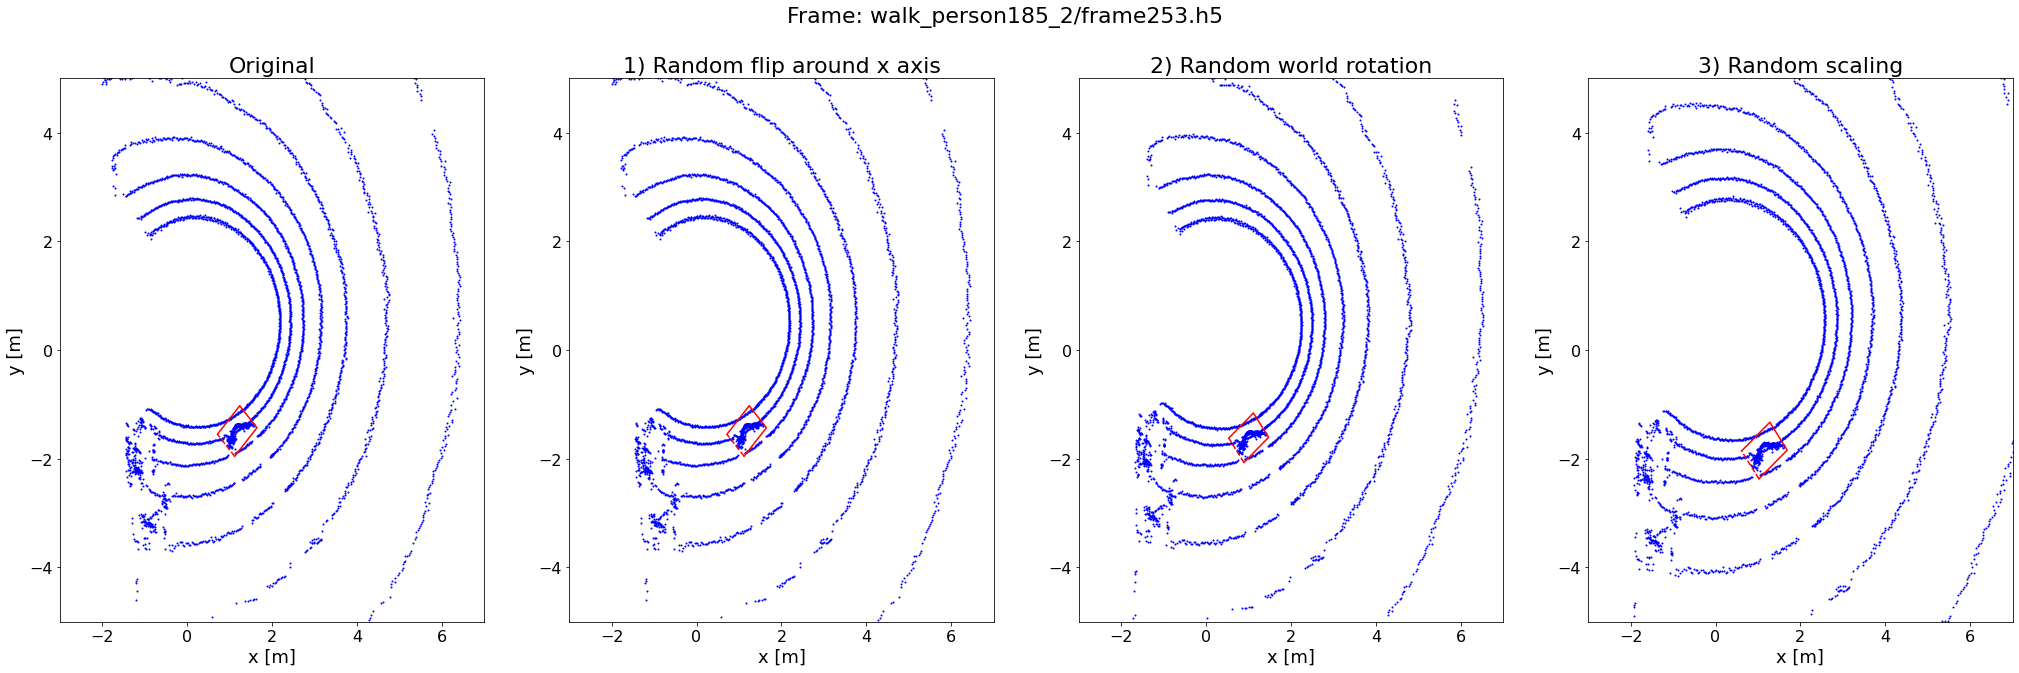

In [48]:
### Show data augmentation pipeline ###

# set frame id 
idx = 266
lidar_file = os.path.join(DATA_PATH, current_samples[idx])
pts_lidar, _, bboxes = load_h5(lidar_file, bbox=True)

# set ax limits for bird's eye view 
ax_limits = [
    [-3, 7], # x
    [-5, 5], # y
]

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
fig = plt.figure(figsize=(35, 10))

gs = GridSpec(1, 4, figure=fig)

ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])
ax_3 = fig.add_subplot(gs[0, 2])
ax_4 = fig.add_subplot(gs[0, 3])

color_pool = np.random.uniform(size=(100, 3))

# compute ground truth bounding boxes 
bbox_list = np.reshape(bboxes, (-1,7)) 
gt_boxes = np.vstack(
    [np.array((float(bbox[0]), float(bbox[1]), float(bbox[2]), # x,y,z
               float(bbox[5]), float(bbox[4]), float(bbox[3]), # w,l,h
               float(bbox[6])), dtype=np.float32) for bbox in bbox_list]) # rz

manipulate_boxes = copy.deepcopy(gt_boxes)
manipylate_pts = copy.deepcopy(pts_lidar)

all_boxes = []
pts_all = []
all_boxes.append(gt_boxes)
pts_all.append(pts_lidar)

# random flip around x 
gt_box_aug1, pts_aug1 = aug.random_flip_along_x(manipulate_boxes, manipylate_pts)
all_boxes.append(gt_box_aug1)
pts_all.append(pts_aug1)

# random world rotation
manipulate_boxes = copy.deepcopy(gt_box_aug1)
manipylate_pts = copy.deepcopy(pts_aug1)
rot_angle_range= [-0.78539816, 0.78539816]
gt_box_aug2, pts_aug2 = aug.global_rotation(manipulate_boxes, manipylate_pts, rot_range=rot_angle_range, rot_mat_alt=False)
all_boxes.append(gt_box_aug2)
pts_all.append(pts_aug2)

# random scaling 
manipulate_boxes = copy.deepcopy(gt_box_aug2)
manipylate_pts = copy.deepcopy(pts_aug2)
scale_range = [0.7, 1.2]
gt_box_aug3, pts_aug3 = aug.global_scaling(manipulate_boxes, manipylate_pts, scale_range)
all_boxes.append(gt_box_aug3)
pts_all.append(pts_aug3)

if type(frame) == str: 
    frame_name = '/'.join(frame.split('/')[-2:])
    auto_save_name = 'data_aug'+str(frame_name.replace('/','_').replace('.h5', '.pdf')) 

axes = [ax_1, ax_2, ax_3, ax_4]
    
for ax,pts,boxes in zip(axes,pts_all,all_boxes): 
    ax.cla()
    ax.set_xlim(*ax_limits[0])
    ax.set_ylim(*ax_limits[1])
    ax.set_xlabel("x [m]", fontsize=18)
    ax.set_ylabel("y [m]", fontsize=18)
    ax.scatter(pts[:,0], pts[:,1], s=1, c='b')
    
    corners_lidar = boxes_to_corners_3d_custom(boxes)# rot_mat_alt=False)
    
    for i in range(corners_lidar.shape[0]):
        corners_lidar2d = corners_lidar[i, :4, :2]
        draw_bev(corners_lidar2d, ax, c='r')

fig.suptitle(f"Frame: {frame_name}", fontsize=22)#, y=0.92)
ax_1.set_title('Original', fontsize=22)
ax_2.set_title("1) Random flip around x axis", fontsize=22)
ax_3.set_title("2) Random world rotation", fontsize=22)
ax_4.set_title("3) Random scaling", fontsize=22)


plot_dir = os.path.dirname(os.path.abspath(os.getcwd()))
plot_dir = os.path.join(plot_dir, "../plots/", auto_save_name)
print(f"Saving to {plot_dir}")
plt.savefig(plot_dir, bbox_inches='tight')   
plt.show()
plt.close('all')